In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from coeval import coeval
from gaiastars import gaiastars as gs,gaiadr2xdr3

import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:

known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')

#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

cluster_names = ['Pleiades', 'alphaPer']
search_results = {}

from gaiastars import from_pickle
import time
import pickle

for cl in cluster_names:
    search_results[cl] = from_pickle(f'./data/search_results_{cl}.pkl')

#exclude the known members returned from the search
for cl in cluster_names:
    merged_fs = search_results[cl].merge(cluster_members[cl])
    print(f'------ {cl} -------')
    print(merged_fs.objs.which.value_counts())
    fs = merged_fs.query('which == \'{} cone search\''.format(cl))
    fs.name = 'Search Results, Known Members excluded'
    search_results[cl] = fs



['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
------ Pleiades -------
Pleiades cone search    107919
both                      1225
Pleiades                   101
Name: which, dtype: int64
------ alphaPer -------
alphaPer cone search    291664
both                       699
alphaPer                    41
Name: which, dtype: int64


In [3]:
these_ones_work = [
    970348221586771840,
    999633297180769280

]

In [4]:
import pickle
coeval_results = {}
travel_times = {}

for cl in cluster_names:
    with open(f'./data/coeval_{cl}.pkl', 'rb') as pkl:
        coeval_results[cl]=pickle.load(pkl)
    with open(f'./data/travel_time_{cl}.pkl', 'rb') as pkl:
        travel_times[cl] = pickle.load(pkl)
    search_results[cl].objs = pd.concat([search_results[cl].objs, coeval_results[cl], travel_times[cl]], axis=1)

In [44]:
def cluster_age_bracket(cluster_info, cluster_name, tol=(0.8, 1.2)):
    cluster_age = 10**cluster_info.loc[cluster_name]['log_age']
    return (cluster_age*tol[0], cluster_age, cluster_age*tol[1])

In [46]:
def rv_lim(star, tt_rec):
    rv_min = tt_rec.rv_min if not np.isfinite(star.radial_velocity.value) else min(tt_rec.rv_min, star.radial_velocity.value)
    rv_max = tt_rec.rv_max if not np.isfinite(star.radial_velocity.value) else max(tt_rec.rv_max, star.radial_velocity.value)

    return (rv_min-1, rv_max+1)

In [65]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_coeval(gstar, star_id, travel_times, cluster_info, cluster_name, rv, times, xlim=None, ylim=None,current_sep=True):
    
    star_i = gstar.objs.index.get_loc(star_id)
    star_coord = gstar.get_coords(recalc=True, default_rv=True)[star_i]
    center = cluster_info.loc[cluster_name]['coords']

    min_age, cluster_age, max_age = cluster_age_bracket(cluster_info, cluster_name)

    test_coeval = coeval(star_coord, center, times, rv)
    min_coeval_i = test_coeval.argmin()
    coeval_i = np.unravel_index(min_coeval_i, test_coeval.shape)
    
    _,tt = gstar._travel_time3d(star_coord,
             center, (min_age*u.year, max_age*u.year), rv=rv,ret_sample=True)
    
    min_rv = rv[coeval_i[0]].value
    ttrec = travel_times.loc[star_id]
    if xlim is None:
        my_xlim = rv_lim(star_coord, ttrec)
    else:
        my_xlim = xlim
    
    fig = plt.figure(figsize=(12,9))
    ax = plt.subplot(111)
    pcm = ax.contourf(rv.value, times*-1.0, test_coeval.T,
                    levels=[0,5,10,15,20, 50],
                    colors=['green','orange','blue','red','lightgrey'],
                    alpha=1.0)
    do_legend = False;
    if current_sep:
        ax.scatter(rv.value, tt, s=10, color='black', label='Current Separation Travel Time')
        do_legend = True
    if np.isfinite(star_coord.radial_velocity.value):
        #print(f'observed radial velocity: {star_coord.radial_velocity.value}')
        ax.axvline(star_coord.radial_velocity.value, ls=':', color = "magenta", lw=3, label='observed radial velocity')
        do_legend= True;

    ax.fill_between(rv, min_age, max_age, color='blue', alpha=0.1)
    ax.fill_between(rv, 0,1, where = np.logical_and(tt.value >= min_age, tt.value<=max_age),
        color='yellow', alpha=0.3, transform=ax.get_xaxis_transform())

    ax.set_xlabel('Radial Velocity (km/s)')
    ax.set_ylabel('Lookback and Travel Time (Years)')
    #ax.invert_yaxis()
    ax.grid()
    ax.set_xlim(my_xlim)
    ax.set_ylim(ylim)
    ax.set_title(f'Separation at Lookback Time and Radial Velocity\nGAIAeDR3 ID: {star_id} relative to cluster: {cluster_name}', fontsize=16, fontweight='bold')
    if do_legend:
        ax.legend(loc='upper right')
    #ax.yaxis.set_ticks_position('right')
    #ax.yaxis.set_label_position('right')
    
    cbaxes = cbaxes = inset_axes(ax, width="7%", height="20%", loc="center right")
    cb = plt.colorbar(pcm, cax = cbaxes,)#label='Star Separation from Center (pc)', rotation=-90)
    cbaxes.set_ylabel('Star Separation from Center (pc)', rotation=-90, labelpad=20)
    #cbaxes.yaxis.set_ticks_position('left')
    #cbaxes.yaxis.set_label_position('left')
    
    return tt


In [12]:
times = np.linspace(-500e6, -50e6, 1000)*u.year
#rv = np.linspace(-100, 100, 1000)*u.km/u.second
rv = np.linspace(-30, 30, 1000)*u.km/u.second

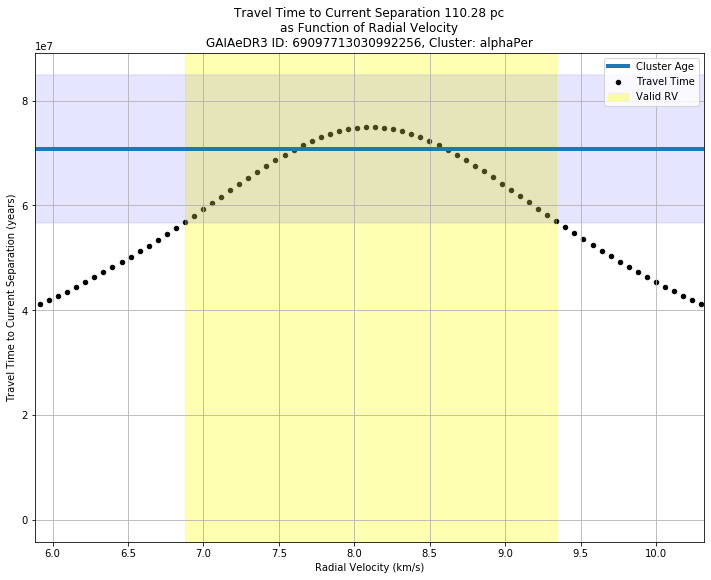

In [32]:
ylim=None
#xlim = (5,15)

cl='alphaPer';
star_id = 69097713030992256
star_i = search_results[cl].objs.index.get_loc(star_id)
star_coord = search_results[cl].get_coords(recalc=True, default_rv=True)[star_i]
tt_rec = travel_times[cl].loc[star_id]
min_age = 10**cluster_info.loc[cl]['log_age']*0.8
max_age = 10**cluster_info.loc[cl]['log_age']*1.2

rv_min = tt_rec.rv_min if not np.isfinite(star_coord.radial_velocity.value) else min(tt_rec.rv_min, star_coord.radial_velocity.value)
rv_max = tt_rec.rv_max if not np.isfinite(star_coord.radial_velocity.value) else max(tt_rec.rv_max, star_coord.radial_velocity.value)

xlim = (rv_min-1, rv_max+1)
#xlim=(-5,20)

current_sep = star_coord.separation_3d(cluster_info.loc[cl]['coords'])
_,tt = search_results[cl]._travel_time3d(star_coord,
             cluster_info.loc[cl]['coords'], 
             (min_age*0.8*u.year, max_age*1.2*u.year), rv=rv,ret_sample=True)

do_legend=True;
fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ax.scatter(rv, tt, s=20, color='black', label='Travel Time')
if np.isfinite(star_coord.radial_velocity.value):
    #print(f'observed radial velocity: {star_coord.radial_velocity.value}')
    ax.axvline(star_coord.radial_velocity.value, ls=':', color = "magenta", lw=3, label='observed radial velocity')
    do_legend=True;

ax.fill_between(rv, 0,1, where = np.logical_and(tt.value >= min_age, tt.value<=max_age),
        color='yellow', alpha=0.3, transform=ax.get_xaxis_transform(), label='Valid RV')
ax.axhline(10**cluster_info.loc[cl]['log_age'], ls='-', lw=4, label='Cluster Age')

ax.fill_between(rv,min_age, max_age, color='blue', alpha=0.1)
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Travel Time to Current Separation (years)')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
ax.grid()
if do_legend:
    ax.legend()
_=ax.set_title(f'Travel Time to Current Separation {current_sep:.2f}\nas Function of Radial Velocity\nGAIAeDR3 ID: {star_id}, Cluster: {cl}')

In [9]:
min_age, max_age

(56635662.75073099, 84953494.12609649)

In [45]:
xlim

(-0.4159999999999997, 18.23187217712402)

In [46]:
tt_rec.rv_min*0.8

-0.4159999999999997

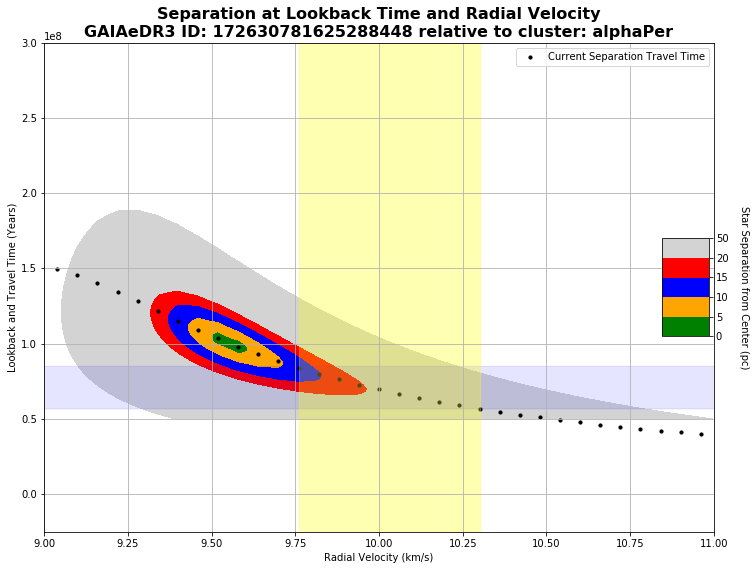

In [71]:
xlim=None;ylim=None
xlim=(9,11); ylim=(None,300e6)
cl='alphaPer';
star_id = 172630781625288448	
tt = plot_coeval(search_results[cl], star_id, travel_times[cl], cluster_info,cl,rv,times, xlim=xlim, ylim=ylim)